In [1]:
from GBP.data import DataGenerator
from GBP.gbp import run_GaBP_SYNC_ACCELERATED, run_GaBP_HARDWARE_ACCELERATED
from GBP.utilities import HiddenPrints
from GBP.visulisation import set_plot_options, get_plot_colors, NetworkxGraph, AnalyzeResult

import warnings
import matplotlib
import numpy as np
import math
import random

# Option 1: Suppress all warnings
warnings.filterwarnings("ignore")

set_plot_options()
colors = get_plot_colors()

data_gen = DataGenerator()
result_analyzer = AnalyzeResult()

In [5]:
num_nodes = 10

A, b = data_gen.get_1D_line_matrix(num_nodes, scaling=True, normalized=False)
# A, b = data_gen.get_2D_lattice_matrix(num_nodes, num_nodes)
graph = NetworkxGraph(A)
# graph.draw_graph()

sync_convergence_threshold = 1*10**-7

In [6]:
sum_of_iterations = 0
num_iterations = 1

for it in range(0,num_iterations):
    print(f"-------------- ITERATION = {it+1} --------------")
    P_i, mu_i, N_i, P_ii, mu_ii, P_ij, mu_ij, iter_dist, stand_divs, means, iteration = run_GaBP_SYNC_ACCELERATED(A, b, max_iter=100000, mae=False, convergence_threshold=sync_convergence_threshold, show=True)
    sum_of_iterations += iteration
    final_mean = list(mu_i)
    final_std = P_i

print(f"AVE. SYNC ITERATIONS = {sum_of_iterations/num_iterations}")

-------------- ITERATION = 1 --------------
iteration: 1
1.4024881107404388
-----
iteration: 2
0.8712818717523412
-----
iteration: 3
0.1469048503613603
-----
iteration: 4
0.06115459372358739
-----
iteration: 5
0.04239934921039441
-----
iteration: 6
0.010413910511669509
-----
iteration: 7
0.0022368943746150205
-----
iteration: 8
0.0008417326462800189
-----
iteration: 9
0.0007660426421087995
-----
iteration: 10
0.0
-----
AVE. SYNC ITERATIONS = 10.0


In [7]:
async_convergence_threshold = 1*10**-5

node_updates_per_pe_LIST = [i for i in range(1, num_nodes+1)]
number_pes_LIST = [i for i in range(1, num_nodes+1)]

dict_of_all_designs = {}
for node_updates_per_pe in node_updates_per_pe_LIST:
    for number_pes in number_pes_LIST:
        if node_updates_per_pe*number_pes <= num_nodes:

            sum_of_iterations = 0
            num_iterations = 100

            for it in range(0,num_iterations):
                P_i, mu_i, iteration = run_GaBP_HARDWARE_ACCELERATED(A, b, node_updates_per_pe=node_updates_per_pe, number_pes=number_pes, TRUE_MEAN=final_mean, max_iter=10000, mae=False, convergence_threshold=async_convergence_threshold, show=False)
                sum_of_iterations += iteration
            print(f"AVE. ASYNC ITERATIONS: (n={node_updates_per_pe}, p={number_pes}) = {sum_of_iterations/num_iterations}")
            dict_of_all_designs[(node_updates_per_pe, number_pes)] = sum_of_iterations/num_iterations

AVE. ASYNC ITERATIONS: (n=1, p=1) = 116.63
AVE. ASYNC ITERATIONS: (n=1, p=2) = 63.21
AVE. ASYNC ITERATIONS: (n=1, p=3) = 44.27
AVE. ASYNC ITERATIONS: (n=1, p=4) = 34.48
AVE. ASYNC ITERATIONS: (n=1, p=5) = 29.46
AVE. ASYNC ITERATIONS: (n=1, p=6) = 26.47
AVE. ASYNC ITERATIONS: (n=1, p=7) = 23.69
AVE. ASYNC ITERATIONS: (n=1, p=8) = 21.69
AVE. ASYNC ITERATIONS: (n=1, p=9) = 19.68
AVE. ASYNC ITERATIONS: (n=1, p=10) = 18.63
AVE. ASYNC ITERATIONS: (n=2, p=1) = 63.44
AVE. ASYNC ITERATIONS: (n=2, p=2) = 34.75
AVE. ASYNC ITERATIONS: (n=2, p=3) = 25.41
AVE. ASYNC ITERATIONS: (n=2, p=4) = 20.53
AVE. ASYNC ITERATIONS: (n=2, p=5) = 18.11
AVE. ASYNC ITERATIONS: (n=3, p=1) = 43.69
AVE. ASYNC ITERATIONS: (n=3, p=2) = 25.26
AVE. ASYNC ITERATIONS: (n=3, p=3) = 18.71
AVE. ASYNC ITERATIONS: (n=4, p=1) = 33.98
AVE. ASYNC ITERATIONS: (n=4, p=2) = 19.36
AVE. ASYNC ITERATIONS: (n=5, p=1) = 27.35
AVE. ASYNC ITERATIONS: (n=5, p=2) = 15.98
AVE. ASYNC ITERATIONS: (n=6, p=1) = 22.9
AVE. ASYNC ITERATIONS: (n=7, p=1)

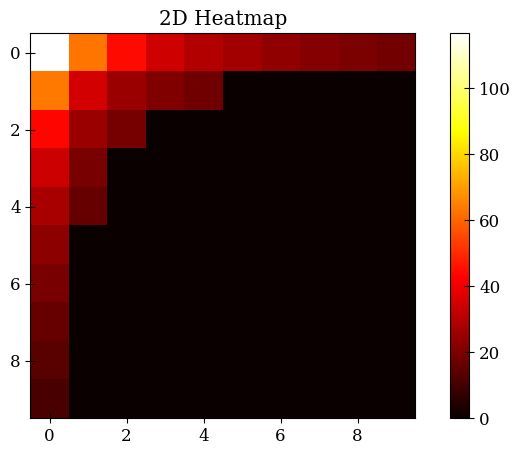

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Determine the size of the heatmap based on the maximum coordinates in the dictionary
max_n = max(key[0] for key in dict_of_all_designs)
max_p = max(key[1] for key in dict_of_all_designs)
heatmap_size = (max_n, max_p)

# Initialize the heatmap data with zeros
data = np.zeros(heatmap_size)

# Populate the heatmap data with values from the dictionary
for key, value in dict_of_all_designs.items():
    n, p = key[0], key[1]
    data[n-1, p-1] = value

# Plot the heatmap
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add colorbar to show the scale
plt.title('2D Heatmap')
plt.show()